## Klasyfikacja ręcznie pisanych liczb - MNIST

Po wykonaniu poprzedniego zadania zleceniodawca znów zadzwonił do Ciebie z kolejnym zadaniem. Okazuje się, że nie wszystkie informacje trafiły do zbioru Tytanic. Brakowało w nim między innymi informacji o pokojach w których mieszkali pasażerowie. Wszystkie informacje o miejscu spania były bowiem zapisane odręcznie na kartkach. Tajemniczy  więc zlecił Ci nowe zadanie... **Stworzenie konwolucyjnej sieci neuronowej rozpoznającej ręcznie pisane cyfry.**

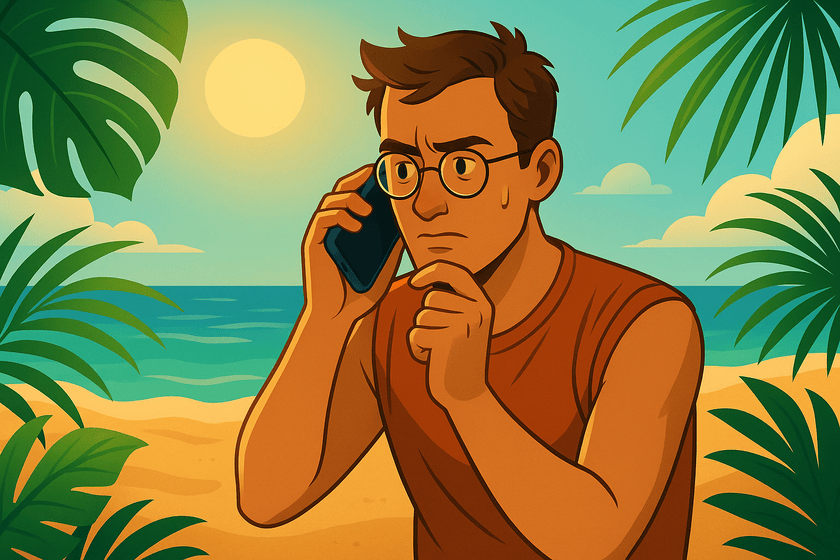

(*AI-generated image*)


#### Twoim celem będzie jest wytrenowanie modelu widzenia komputerowego (CNN) do klasyfikacji każdej ręcznie pisanej liczby z jak najlepszą dokładnością.

Poniżej znajdziesz pytania, które mogą być pomocne w zadaniu:

- Co mój model robi i w jaki sposób?
- Na czym skupia się mój model?
- Jakie liczby mój model myli? Dlaczego?
- Jak uodpornić mój model?
- Jaki wynik klasyfikacji możemy uznać za *dobry*?


Wymagania:
- Wypisz obserwacje z pierwszego zadania, które pomogą Ci w tym. Co było przydatne, a co okazało się bezużyteczne?
- Stwórz baseline, czyli dla porównania sprawdź jak z zadaniem radzi sobie zwykła sieć (nie musi być na wszystkich próbkach - zajmie to długo)
- W badaniach użyj wybranych metryk. Wybór uzasadnij.
- Spróbuj dobrać strukture sieci (szerokość i wysokość) i sprawdź jaki ma wpływ na dokładność
- Ćwiczenie: zmień liczbę kanałów/warstw, dodaj BatchNorm, spróbuj zwiększyć/zmniejszyć dropout.
- Wypisz wnioski.
- Korzystaj z `PyTorch` (`torch, torchvision`)

Niezmiennie, zadbaj o czytelność kodu i nazewnictwo zmiennych. Jeśli jakiś wycinek kodu się powtarza, to wyodrębnij go do funkcji. Postaraj się zamieszczać swoje wnioski w postaci komentarza `Markdown`.

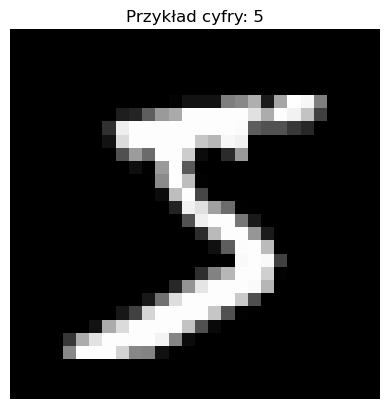

In [53]:
# ładowanie zbioru danych
import tensorflow as tf
import matplotlib.pyplot as plt

(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()


plt.imshow(x_train[0], cmap='gray')
plt.title(f"Przykład cyfry: {y_train[0]}")
plt.axis('off')
plt.show()

Przygotowanie danych

In [54]:
import torch
from torch.utils.data import DataLoader, random_split
from torchvision import datasets, transforms

SEED = 42
torch.manual_seed(SEED)

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
])

data_root = "./data"
train_full = datasets.MNIST(root=data_root, train=True, download=True, transform=transform)
test_ds    = datasets.MNIST(root=data_root, train=False, download=True, transform=transform)

val_size = 5000
train_size = len(train_full) - val_size
train_ds, val_ds = random_split(train_full, [train_size, val_size], generator=torch.Generator().manual_seed(SEED))

BATCH_SIZE = 64
train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True, num_workers=2, pin_memory=True)
val_loader   = DataLoader(val_ds, batch_size=BATCH_SIZE, shuffle=False, num_workers=2, pin_memory=True)
test_loader  = DataLoader(test_ds, batch_size=BATCH_SIZE, shuffle=False, num_workers=2, pin_memory=True)

len(train_ds), len(val_ds), len(test_ds)

(55000, 5000, 10000)

Baseline

In [55]:
import torch.nn as nn
import torch.nn.functional as F
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

class BaselineCNN(nn.Module):
    def __init__(self):
        super(BaselineCNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.pool  = nn.MaxPool2d(2, 2)
        self.dropout = nn.Dropout(0.25)
        self.fc1 = nn.Linear(64 * 7 * 7, 128)
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.dropout(x)
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

model = BaselineCNN().to(device)

In [56]:
class BaselineMLP(nn.Module):
    def __init__(self):
        super(BaselineMLP, self).__init__()
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(28 * 28, 256)
        self.fc2 = nn.Linear(256, 128)
        self.fc3 = nn.Linear(128, 10)

    def forward(self, x):
        x = self.flatten(x)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        return self.fc3(x)

model = BaselineMLP().to(device)


In [57]:
class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 16, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, padding=1)
        self.fc1 = nn.Linear(32 * 7 * 7, 128)

        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 32 * 7 * 7)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)                        
        return x
    
model = SimpleCNN().to(device)

In [58]:
sample_input = torch.randn(64, 1, 28, 28).to(device)

output = model(sample_input)
print(output.shape)


torch.Size([64, 10])


Trening

In [59]:
def run_epoch(model, loader, criterion, optimizer=None, train=False):
    device = next(model.parameters()).device
    model.train() if train else model.eval()

    total_loss, correct, total = 0, 0, 0
    for xb, yb in loader:
        xb, yb = xb.to(device), yb.to(device)
        if train:
            optimizer.zero_grad()
        with torch.set_grad_enabled(train):
            logits = model(xb)
            loss = criterion(logits, yb)
            if train:
                loss.backward()
                optimizer.step()
        total_loss += loss.item() * xb.size(0)
        preds = logits.argmax(dim=1)
        correct += (preds == yb).sum().item()
        total += yb.size(0)
    return total_loss / total, correct / total


In [60]:
from torch.optim import Adam

def train_model(model, train_loader, val_loader, epochs=5, lr=1e-3):
    model = model.to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = Adam(model.parameters(), lr=lr)
    history = {"train_loss": [], "train_acc": [], "val_loss": [], "val_acc": []}

    for epoch in range(1, epochs+1):
        tr_loss, tr_acc = run_epoch(model, train_loader, criterion, optimizer, train=True)
        val_loss, val_acc = run_epoch(model, val_loader, criterion, train=False)
        history["train_loss"].append(tr_loss)
        history["train_acc"].append(tr_acc)
        history["val_loss"].append(val_loss)
        history["val_acc"].append(val_acc)
        print(f"Epoch {epoch}: Train acc {tr_acc:.4f}, Val acc {val_acc:.4f}")
    
    return history

c:\Users\jastr\anaconda3\Lib\site-packages\torch\utils\data\dataloader.py:666: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Epoch 1: Train acc 0.9493, Val acc 0.9798
Epoch 2: Train acc 0.9838, Val acc 0.9838
Epoch 3: Train acc 0.9879, Val acc 0.9872
Epoch 4: Train acc 0.9910, Val acc 0.9864
Epoch 5: Train acc 0.9932, Val acc 0.9876


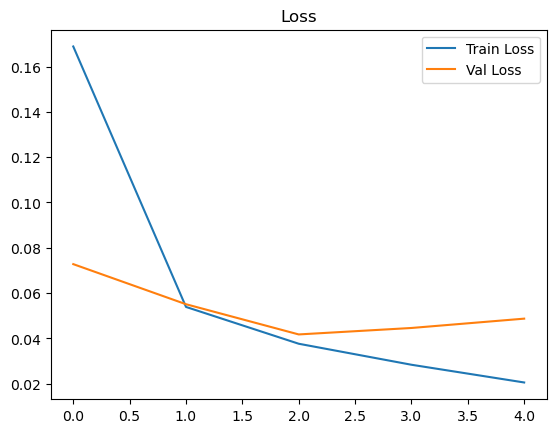

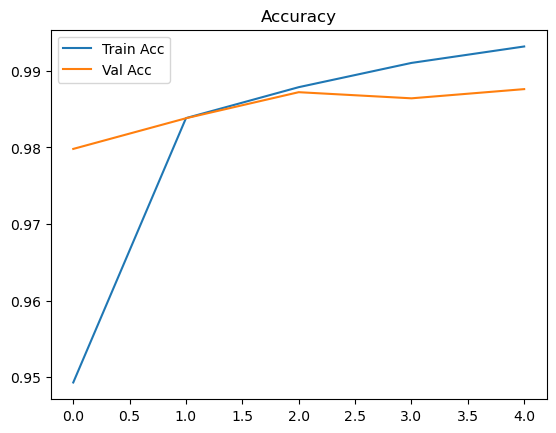

In [61]:
import matplotlib.pyplot as plt

history = train_model(model, train_loader, val_loader, epochs=5, lr=1e-3)

plt.plot(history["train_loss"], label="Train Loss")
plt.plot(history["val_loss"], label="Val Loss")
plt.legend(); plt.title("Loss"); plt.show()

plt.plot(history["train_acc"], label="Train Acc")
plt.plot(history["val_acc"], label="Val Acc")
plt.legend(); plt.title("Accuracy"); plt.show()

Ewaluacja

Test accuracy: 0.9883


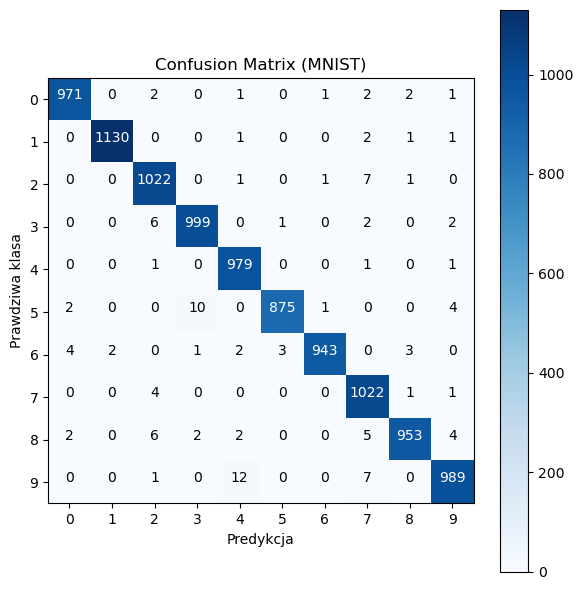

              precision    recall  f1-score   support

           0     0.9918    0.9908    0.9913       980
           1     0.9982    0.9956    0.9969      1135
           2     0.9808    0.9903    0.9855      1032
           3     0.9872    0.9891    0.9881      1010
           4     0.9810    0.9969    0.9889       982
           5     0.9954    0.9809    0.9881       892
           6     0.9968    0.9843    0.9905       958
           7     0.9752    0.9942    0.9846      1028
           8     0.9917    0.9784    0.9850       974
           9     0.9860    0.9802    0.9831      1009

    accuracy                         0.9883     10000
   macro avg     0.9884    0.9881    0.9882     10000
weighted avg     0.9884    0.9883    0.9883     10000



In [62]:
from sklearn.metrics import confusion_matrix, classification_report
import itertools
import numpy as np

model.eval()
all_preds, all_targets = [], []

with torch.no_grad():
    for xb, yb in test_loader:
        xb = xb.to(device, non_blocking=True)
        logits = model(xb)
        preds = logits.argmax(1).cpu().numpy()
        all_preds.append(preds)
        all_targets.append(yb.numpy())

y_pred = np.concatenate(all_preds)
y_true = np.concatenate(all_targets)

test_acc = (y_pred == y_true).mean()
print(f"Test accuracy: {test_acc:.4f}")

cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(6,6))
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title("Confusion Matrix (MNIST)")
plt.colorbar()
tick_marks = np.arange(10)
plt.xticks(tick_marks, tick_marks)
plt.yticks(tick_marks, tick_marks)

thresh = cm.max() / 2.0
for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, f"{cm[i, j]}", ha="center", 
             color="white" if cm[i, j] > thresh else "black")

plt.ylabel('Prawdziwa klasa')
plt.xlabel('Predykcja')
plt.tight_layout()
plt.show()

print(classification_report(y_true, y_pred, digits=4))




c:\Users\jastr\anaconda3\Lib\site-packages\torch\utils\data\dataloader.py:666: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


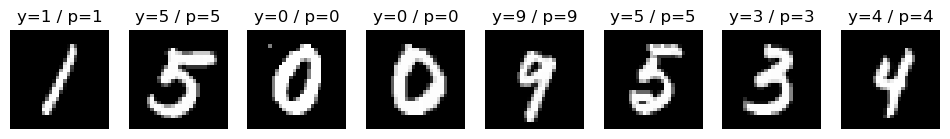

In [63]:
import random

model.eval()
batch = random.choice(list(test_loader))
images, labels = batch[0][:8], batch[1][:8]
with torch.no_grad():
    logits = model(images.to(device))
preds = logits.argmax(1).cpu()

fig, axes = plt.subplots(1, len(images), figsize=(12, 2.5))
for ax, img, y, p in zip(axes, images, labels, preds):
    ax.imshow(img.squeeze().numpy(), cmap="gray")
    ax.set_title(f"y={y.item()} / p={int(p)}")
    ax.axis("off")
plt.show()

Zapis i ładowanie

In [64]:
import os

save_path = "mnist_cnn.pt"
torch.save(model.state_dict(), save_path)
print(f"Model zapisany do: {os.path.abspath(save_path)}")

# do ładowania odkomentuj poniższe:
# Ładowanie:
model = SimpleCNN().to(device)
model.load_state_dict(torch.load(save_path, map_location=device))
model.eval()

Model zapisany do: c:\Users\jastr\OneDrive\Desktop\ml-wakacyjne-wyzwanie-2025\3_nn&cv\mnist_cnn.pt


SimpleCNN(
  (conv1): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (fc1): Linear(in_features=1568, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=10, bias=True)
)